# 불균형 데이터 문제 해결 방법론 적용
---

## 1. 신용카드 정보를 이용한 사기 탐지
---
### 1.1 라이브러리 설치, 로드 후 데이터 로드



다양한 샘플링 클래스를 제공하는 imblearn(imbalanced-learn) 모듈을 설치하여 사용하도록 하겠습니다.

In [2]:
# !pip install scikit-learn==1.1.3
# !pip install imbalanced-learn==0.11.0

- **pandas**: 데이터프레임을 다루기 위한 라이브러리
- **sklearn**: 머신러닝을 다루기 위한 라이브러리

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# 모델 학습 시 random_state를 고정적으로 사용하기 위해 random_state 변수를 75로 설정합니다.
random_state = 75

**데이터 압축 해제**
* 실습에 사용할 데이터의 크기가 매우 커서 zip파일로 저장되어있습니다. shutil 라이브러리를 사용해 압축을 해제한 뒤 사용합니다.

In [4]:
import shutil
# 파일 시스템 접근 라이브러리 (import os랑 유사)

filename = "creditcard.zip"
extract_dir = "./"
archive_format = "zip"

shutil.unpack_archive(filename, extract_dir, archive_format)
# ./creditcard.zip 압축 해제

**데이터 설명**

- Time: 해당 트랜잭션과 첫 번쨰 트랜잭션 사이에 경과된 시간
- V1 ~ V28: PCA를 거쳐 산출된 항목입니다.
- Amount: 트랜잭션 양
- Class: 1은 사기, 0은 정상

In [5]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.2 데이터 분석 및 시각화

In [6]:
df.shape

(284807, 31)

데이터의 통계치를 파악합니다.

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Null 값을 체크합니다.

In [8]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
df.isnull().sum().sum()

0

컬럼들을 체크합니다.

In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

`Class` 비율을 확인합니다.

In [11]:
len_df = len(df)

print(f"정상거래: {((df.Class.value_counts()[0] / len_df) * 100):.4f} %")
print(f"사기거래: {((df.Class.value_counts()[1] / len_df) * 100):.4f} %")

정상거래: 99.8273 %
사기거래: 0.1727 %


`Amount`와 `Time`에 대한 분포를 확인합니다.

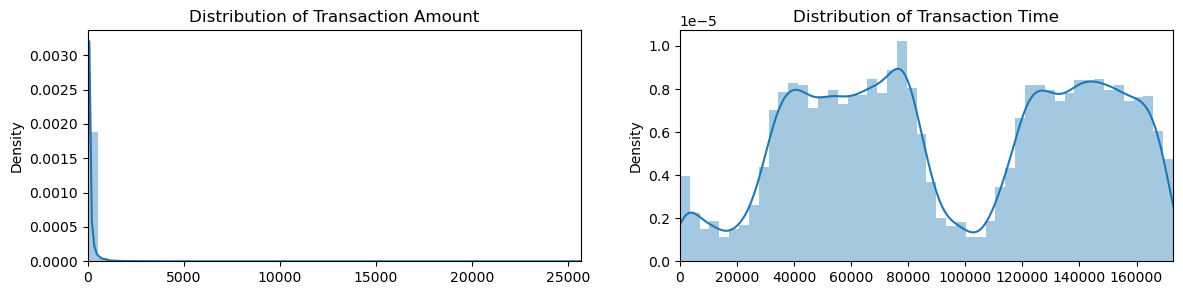

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14,3))

amount_val = df.Amount.values
time_val = df.Time.values

sns.distplot(amount_val, ax=ax[0])
ax[0].set_title("Distribution of Transaction Amount")
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1])
ax[1].set_title("Distribution of Transaction Time")
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [13]:
max(time_val)

172792.0

In [14]:
max(time_val)/24/60/60  # sec 단위 : 초당 2개씩 데이터 찍힘 (0.5초에 하나씩)

1.9999074074074075

### 1.3 데이터 전처리

`Amount`와 `Time`에 RobustScaler를 적용합니다.

In [15]:
rob_scaler = RobustScaler()  # 데이터를 백분위수 중심으로 스케일링 (중위값 50%를 0으로 두고, 25~75% 거리를 IQR=1이 되도록 조정한 스케일러)
# scaled 거리가 1
df['scaled_amount'] = rob_scaler.fit_transform(df.Amount.values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df.Time.values.reshape(-1,1))

# df.drop(['Time','Amount'], axis=1, inplace=True)

In [16]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274,-0.994983
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825,-0.994983
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721,-0.994972
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291,-0.994972
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,-0.296653,1.034951
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0.038986,1.034963
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0.641096,1.034975
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,-0.167680,1.034975


In [17]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727,0.927124,0.118914
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,3.495006,0.557903
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,-0.307413,-0.994983
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,-0.229162,-0.358210
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,0.770838,0.641790
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,358.683155,1.035022


`X`에 `Class`를 제외한 `df`를, `y`에 `Class`를 저장합니다.

In [18]:
X = df.drop('Class', axis=1)
y = df.Class

랜덤 언더샘플링을 진행 후 셔플합니다.

In [19]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [20]:
df[df.Class==1][:492]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,-0.307413,-0.990214
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,7.084469,-0.989438
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,3.045204,-0.942563
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1,0.517013,-0.912910
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,-0.293440,-0.906648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1,5.142178,0.992140
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1,-0.296793,0.994549
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1,0.780968,0.994596
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1,3.116048,1.001821


In [21]:
df[df.Class==1].sample(n=492)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
157871,110552.0,-2.450367,2.107729,-5.140663,1.411304,-1.690780,-0.736427,-3.657946,1.944906,-0.788388,...,0.233608,-0.282078,-0.320311,0.492920,0.359976,-0.115471,80.22,1,0.813526,0.303810
141258,84204.0,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,...,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,0.00,1,-0.307413,-0.005733
124087,77171.0,1.118560,1.291858,-1.298805,2.135772,0.772204,-1.147291,0.390578,-0.107072,-0.038339,...,-0.102326,0.017911,0.650302,-0.332366,0.105949,0.128124,1.00,1,-0.293440,-0.088359
6870,8757.0,-1.863756,3.442644,-4.468260,2.805336,-2.118412,-2.332285,-4.261237,1.701682,-1.439396,...,-0.012218,0.070614,0.058504,0.304883,0.418012,0.208858,1.00,1,-0.293440,-0.892104
61787,49985.0,-1.554216,1.694229,-0.903334,2.425436,-2.899787,0.133028,-0.286226,0.555945,-1.394918,...,0.202350,0.492054,-0.183791,-0.199917,0.395201,0.027693,360.00,1,4.722979,-0.407747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93424,64412.0,-1.348042,2.522821,-0.782432,4.083047,-0.662280,-0.598776,-1.943552,-0.329579,-1.853274,...,-0.218358,0.125866,-0.074180,0.179116,0.612580,0.234206,1.00,1,-0.293440,-0.238255
14170,25198.0,-15.903635,10.393917,-19.133602,6.185969,-12.538021,-4.027030,-13.897827,10.662252,-2.844954,...,-0.601295,0.040404,0.995502,-0.273743,1.688136,0.527831,99.99,1,1.089779,-0.698951
245556,152802.0,1.322724,-0.843911,-2.096888,0.759759,-0.196377,-1.166353,0.482534,-0.349791,1.045007,...,-0.208574,-0.254752,-0.098324,-0.613874,0.002654,0.072386,357.95,1,4.694334,0.800174
16780,28143.0,-27.143678,15.365804,-28.407424,6.370895,-20.087878,-4.666313,-18.709479,17.903574,-3.722279,...,-0.902247,0.144011,2.024388,-0.204214,1.332153,0.385891,99.99,1,1.089779,-0.664352


### Undersample data 추가 - 구분 잘 되는 노랜덤 샘플

In [22]:
normal_distributed_df = pd.concat([  # 앞에는 클래스 0, 뒤에는 클래스 1 → frac=1 섞어라
    df[df.Class == 1],   # class가 1인 것이 갯수가 적다
    df[df.Class == 0][:492]  # time이 앞쪽에 몰리니 랜덤은 아니다 → Time이 앞쪽에 몰리면 잘 구분된다. time에 따라 구분될 뿐
#     df[df.Class==0].sample(n=492)  # 이게 랜덤이다 → 구분 잘 안 됨 (현실적임)
])
under_samp_df = normal_distributed_df.sample(frac=1, random_state=random_state)  # 섞으란 뜻이다
under_samp_df.head(5)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
351,259.0,-1.569485,-1.932133,1.249203,-4.434211,1.244282,0.402688,-0.649554,0.534756,0.886183,...,0.199030,-1.386013,-0.141955,-0.984011,0.274079,-0.019784,55.45,0,0.467407,-0.991941
192382,129668.0,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,...,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,2.00,1,-0.279466,0.528390
41,32.0,-2.008872,2.198527,0.144242,1.159432,-0.815174,0.182288,-0.617108,1.530817,-0.586832,...,0.011081,0.015249,0.034211,-0.236141,0.128291,0.117986,2.35,0,-0.274576,-0.994608
6719,8415.0,-0.251471,4.313523,-6.891438,6.796797,0.616297,-2.966327,-2.436653,0.489328,-3.371639,...,-0.605240,-0.263743,1.539916,0.523574,0.891025,0.572741,1.00,1,-0.293440,-0.896122
83297,59777.0,-8.257111,-4.814461,-5.365307,1.204230,-3.347420,-1.331601,-1.967893,1.295438,-1.674415,...,-3.091624,-0.390201,-0.288689,-0.340004,0.039819,-1.007900,319.20,1,4.152868,-0.292708


언더샘플링을 적용한 `under_samp_df`의 class 비율을 확인합니다.

In [23]:
len_df

284807

In [24]:
len_df = len(under_samp_df)

print(f"정상거래: {((under_samp_df.Class.value_counts()[0] / len_df) * 100):.4f} %")
print(f"사기거래: {((under_samp_df.Class.value_counts()[1] / len_df) * 100):.4f} %")

정상거래: 50.0000 %
사기거래: 50.0000 %


`df`와 `under_samp_df`의 상관관계를 확인합니다.

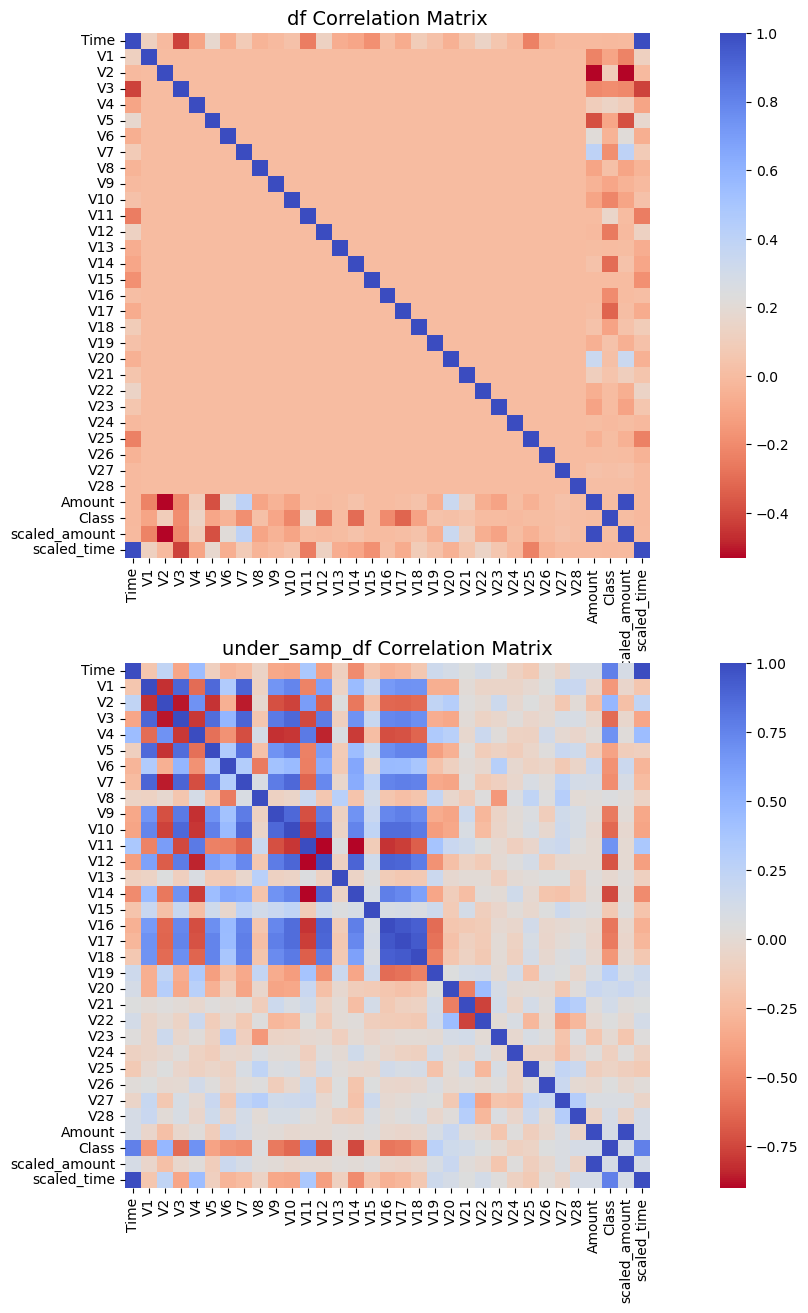

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,15))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1, square=True)
ax1.set_title("df Correlation Matrix", fontsize=14)


corr = under_samp_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2, square=True)
ax2.set_title('under_samp_df Correlation Matrix', fontsize=14)
plt.show()

`under_X`에 `Class`를 제외한 `under_samp_df`를, `under_y`에 `Class`를 저장합니다.

In [26]:
under_X = under_samp_df.drop("Class", axis=1)
under_y = under_samp_df.Class

>- TSNE
>- PCA

`under_X`에 TSNE를 적용하고 수행시간을 확인합니다.

In [27]:
strat_time = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=random_state).fit_transform(under_X.values)
done_time = time.time()
print(f"T-SNE took {(done_time - strat_time):.1f} s")


T-SNE took 1.3 s


TSNE 결과를 시각화합니다.

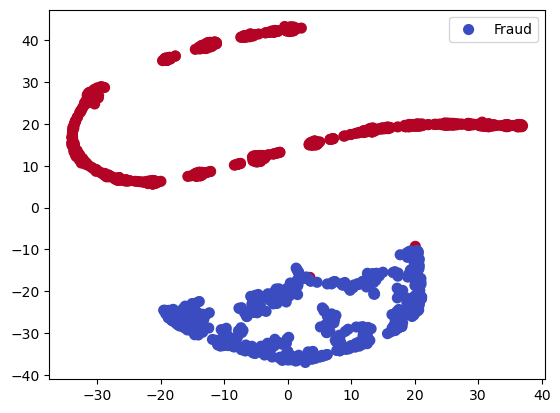

In [28]:
# plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(under_y == 0), cmap="coolwarm", label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(under_y == 1), cmap="coolwarm", label='Fraud', linewidths=2)
plt.legend()

`under_X`에 PCA를 적용하고 수행시간을 확인합니다.

In [29]:
strat_time = time.time()
X_reduced_pca = PCA(n_components=2, random_state=random_state).fit_transform(under_X.values)
done_time = time.time()
print(f"PCA took {(done_time - strat_time):.1f} s")

PCA took 0.0 s


PCA 결과를 시각화합니다.

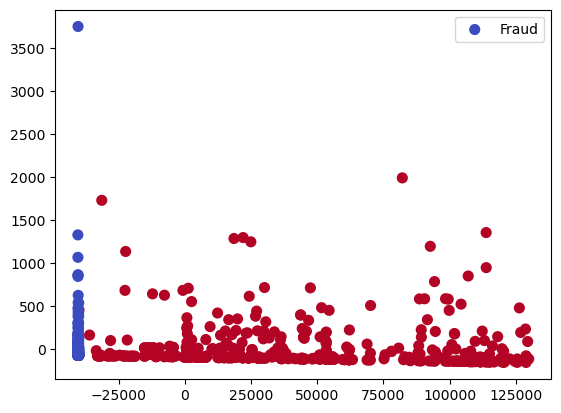

In [30]:
# plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(under_y == 0), cmap="coolwarm", label='No Fraud', linewidths=2)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(under_y == 1), cmap="coolwarm", label='Fraud', linewidths=2)
plt.legend()

### Undersample data 추가 - 구분 잘 안 되는 찐랜덤 샘플

In [37]:
normal_distributed_df1 = pd.concat([  # 앞에는 클래스 0, 뒤에는 클래스 1 → frac=1 섞어라
    df[df.Class == 1],   # class가 1인 것이 갯수가 적다
#     df[df.Class == 0][:492]  # time이 앞쪽에 몰리니 랜덤은 아니다 → Time이 앞쪽에 몰리면 잘 구분된다. time에 따라 구분될 뿐
    df[df.Class==0].sample(n=492)  # 이게 랜덤이다 → 구분 잘 안 됨 (현실적임)
])
under_samp_df1 = normal_distributed_df1.sample(frac=1, random_state=random_state)  # 섞으란 뜻이다
under_samp_df1.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
237030,149064.0,1.963548,-0.036217,-1.905151,0.213076,1.048693,0.669010,-0.097779,0.233602,0.593074,...,0.406072,-0.673683,-0.465113,0.279159,-0.017057,-0.044783,0.89,0,-0.294977,0.756259
192382,129668.0,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,...,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,2.00,1,-0.279466,0.528390
263574,161017.0,-0.150815,0.932155,0.483187,-0.544876,0.949161,-0.526020,1.094575,-0.246048,-0.515698,...,-0.156245,-0.681938,-0.345439,0.280641,0.094827,0.145737,1.98,0,-0.279746,0.896686
6719,8415.0,-0.251471,4.313523,-6.891438,6.796797,0.616297,-2.966327,-2.436653,0.489328,-3.371639,...,-0.605240,-0.263743,1.539916,0.523574,0.891025,0.572741,1.00,1,-0.293440,-0.896122
83297,59777.0,-8.257111,-4.814461,-5.365307,1.204230,-3.347420,-1.331601,-1.967893,1.295438,-1.674415,...,-3.091624,-0.390201,-0.288689,-0.340004,0.039819,-1.007900,319.20,1,4.152868,-0.292708


언더샘플링을 적용한 `under_samp_df1`의 class 비율을 확인합니다.

In [38]:
len_df1 = len(under_samp_df1)

print(f"정상거래: {((under_samp_df1.Class.value_counts()[0] / len_df1) * 100):.4f} %")
print(f"사기거래: {((under_samp_df1.Class.value_counts()[1] / len_df1) * 100):.4f} %")

정상거래: 50.0000 %
사기거래: 50.0000 %


`df`와 `under_samp_df1`의 상관관계를 확인합니다.

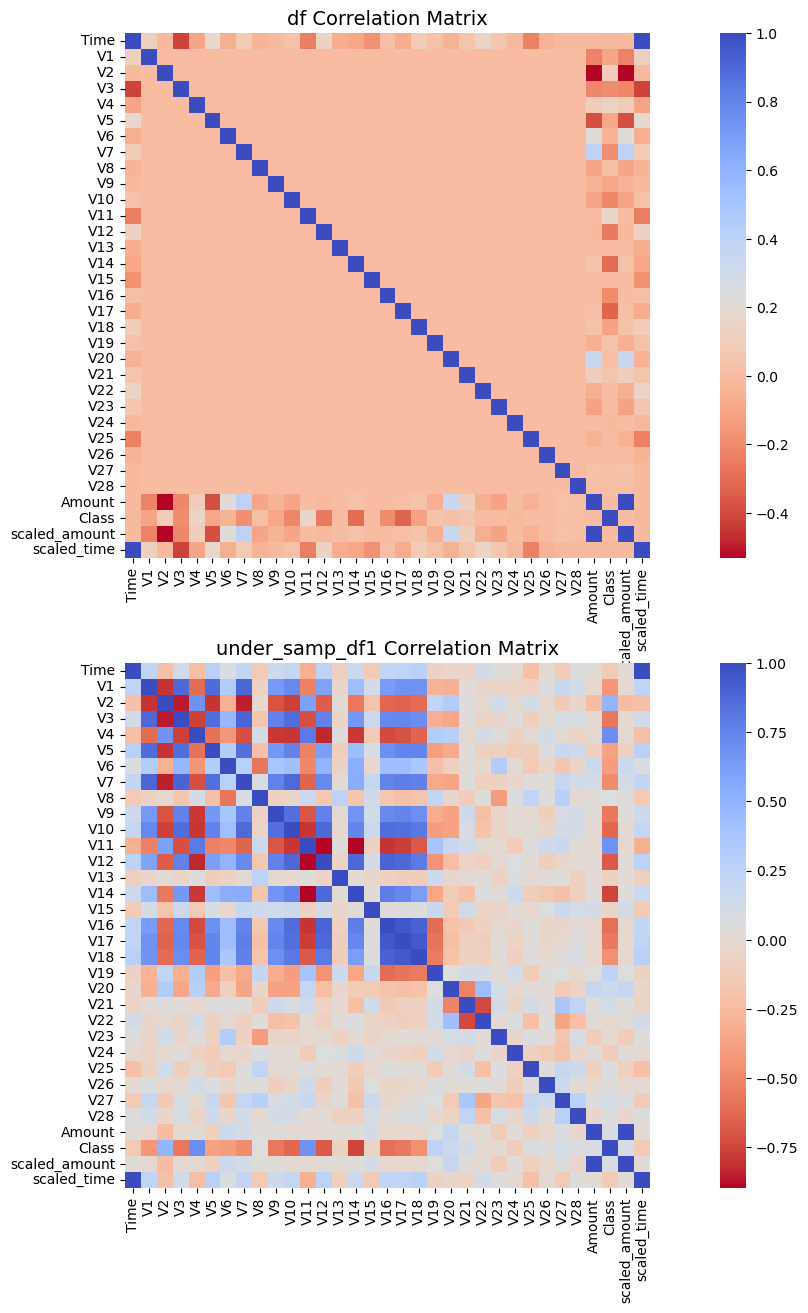

In [40]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,15))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1, square=True)
ax1.set_title("df Correlation Matrix", fontsize=14)


corr = under_samp_df1.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2, square=True)
ax2.set_title('under_samp_df1 Correlation Matrix', fontsize=14)
plt.show()

In [41]:
under_X1 = under_samp_df1.drop("Class", axis=1)
under_y1 = under_samp_df1.Class

>- TSNE
>- PCA

`under_X1`에 TSNE를 적용하고 수행시간을 확인합니다.

In [42]:
strat_time = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=random_state).fit_transform(under_X1.values)
done_time = time.time()
print(f"T-SNE took {(done_time - strat_time):.1f} s")


T-SNE took 1.3 s


TSNE 결과를 시각화합니다.

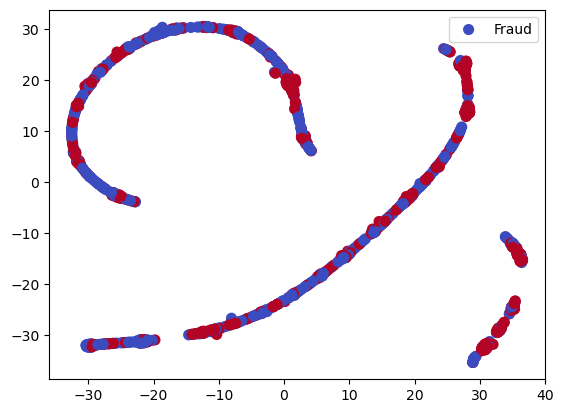

In [45]:
# plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(under_y1 == 0), cmap="coolwarm", label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(under_y1 == 1), cmap="coolwarm", label='Fraud', linewidths=2)
plt.legend()

`under_X1
`에 PCA를 적용하고 수행시간을 확인합니다.

In [46]:
strat_time = time.time()
X_reduced_pca = PCA(n_components=2, random_state=random_state).fit_transform(under_X1.values)
done_time = time.time()
print(f"PCA took {(done_time - strat_time):.1f} s")

PCA took 0.0 s


PCA 결과를 시각화합니다.

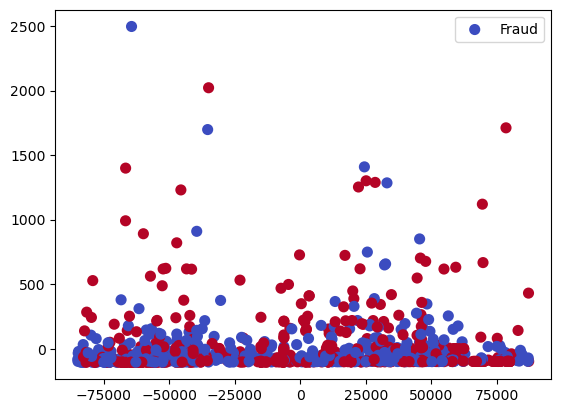

In [47]:
# plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(under_y1 == 0), cmap="coolwarm", label='No Fraud', linewidths=2)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(under_y1 == 1), cmap="coolwarm", label='Fraud', linewidths=2)
plt.legend()

X, y, under_X, under_y에 train_test_split을 적용합니다.

In [48]:
# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
under_X_train, under_X_test, under_y_train, under_y_test = train_test_split(under_X, under_y, test_size=0.2, random_state=random_state)
under_X_train1, under_X_test1, under_y_train1, under_y_test1 = train_test_split(under_X1, under_y1, test_size=0.2, random_state=random_state)
# 언더 샘플한 걸 train/test split

### 1.4 모델 학습 및 성능 테스트

학습 할 모델들을 선언하여 `models`에 저장합니다.

In [49]:
models = { # 분류 모델
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

모델의 성능을 측정하고 출력하는 `performance_printer`를 제작합니다.

In [50]:
def performance_printer(model_name, y_test, y_pred):  # 정답과 예측값을 받았을 때 혼동행렬 출력해주는 함수를 만든다
    # 예측된 값인 y_pred와 실제 값인 y_test를 이용하여 accuracy, f1_score recall, precision을 산출합니다.
    # f1_score 산출 시 average parameter를 macro로 설정합니다.
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"{model_name}", end="\t")
    print(f"accuracy: {accuracy:.4f}", end="    ")
    print(f"f1_score: {f1:.4f}", end="    ")
    print(f"recall: {recall:.4f}", end="    ")
    print(f"precision: {precision:.4f}")

for문을 이용하여 앞에서 `models`를 학습하고 성능을 평가합니다.

데이터는 **언더샘플링을 적용하기 전의 데이터**를 사용합니다.

In [51]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(np.array(X_test))
    performance_printer(model_name, y_test, y_pred)

LogisiticRegression	accuracy: 0.9992    f1_score: 0.8645    recall: 0.7294    precision: 0.7294
KNearest	accuracy: 0.9986    f1_score: 0.5757    recall: 0.0824    precision: 1.0000
Support Vector Classifier	accuracy: 0.9985    f1_score: 0.4996    recall: 0.0000    precision: 0.0000
DecisionTreeClassifier	accuracy: 0.9990    f1_score: 0.8503    recall: 0.8000    precision: 0.6239


학습 할 모델들을 선언하여 `models`에 저장합니다.

In [52]:
models = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for문을 이용하여 앞에서 `models`를 학습하고 성능을 평가합니다.

데이터는 **언더샘플링을 적용한 후의 잘 구분되는 데이터**를 사용합니다.

In [54]:
for model_name, model in models.items():
    model.fit(under_X_train, under_y_train)
    under_y_pred = model.predict(np.array(under_X_test))
    performance_printer(model_name, under_y_test, under_y_pred)

LogisiticRegression	accuracy: 1.0000    f1_score: 1.0000    recall: 1.0000    precision: 1.0000
KNearest	accuracy: 1.0000    f1_score: 1.0000    recall: 1.0000    precision: 1.0000
Support Vector Classifier	accuracy: 0.9898    f1_score: 0.9898    recall: 0.9792    precision: 1.0000
DecisionTreeClassifier	accuracy: 1.0000    f1_score: 1.0000    recall: 1.0000    precision: 1.0000


학습 할 모델들을 선언하여 `models`에 저장합니다.

In [55]:
models = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for문을 이용하여 앞에서 `models`를 학습하고 성능을 평가합니다.

데이터는 **언더샘플링을 적용한 후의 랜덤 샘플링 데이터**를 사용합니다.

In [56]:
for model_name, model in models.items():
    model.fit(under_X_train1, under_y_train1)
    under_y_pred1 = model.predict(np.array(under_X_test1))
    performance_printer(model_name, under_y_test1, under_y_pred1)

LogisiticRegression	accuracy: 0.9594    f1_score: 0.9593    recall: 0.9375    precision: 0.9783
KNearest	accuracy: 0.6802    f1_score: 0.6801    recall: 0.6771    precision: 0.6701
Support Vector Classifier	accuracy: 0.5279    f1_score: 0.5255    recall: 0.6146    precision: 0.5130
DecisionTreeClassifier	accuracy: 0.9086    f1_score: 0.9086    recall: 0.9271    precision: 0.8900
